**심층 신경망 훈련하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 그레이디언트 소실과 폭주 문제

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


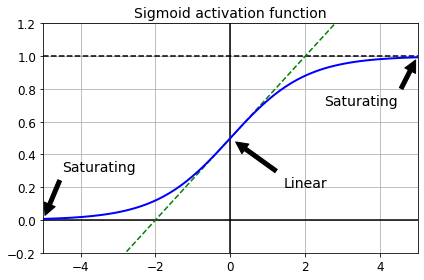

In [3]:
import numpy as np

z = np.linspace(-5, 5, 200)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot([-5, 5], [-3 / 4, 7 / 4], "g--")
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor="black", shrink=0.1)
plt.annotate("Saturating", xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate("Saturating", xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate("Linear", xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier 초기화와 He 초기화

In [4]:
from tensorflow import keras

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## 수렴하지 않는 활성화 함수

### LeakyReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

그림 저장: leaky_relu_plot


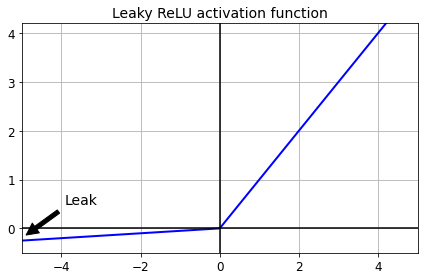

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-0.5, 4.2], "k-")
plt.grid(True)
props = dict(facecolor="black", shrink=0.1)
plt.annotate("Leak", xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련해 본다:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [13]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 1.3308 - accuracy: 0.6031 - val_loss: 0.8936 - val_accuracy: 0.7122
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7998 - accuracy: 0.7385 - val_loss: 0.7177 - val_accuracy: 0.7672
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6846 - accuracy: 0.7767 - val_loss: 0.6407 - val_accuracy: 0.7888
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6229 - accuracy: 0.7957 - val_loss: 0.5946 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5830 - accuracy: 0.8071 - val_loss: 0.5607 - val_accuracy: 0.8178
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5550 - accuracy: 0.8144 - val_loss: 0.5369 - val_accuracy: 0.8256
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5339 - accuracy: 0.8203 - val_loss: 0.5211 - val_accuracy:

PReLU를 테스트해 본다:

In [15]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [17]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.3709 - accuracy: 0.6027 - val_loss: 0.9355 - val_accuracy: 0.7008
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8302 - accuracy: 0.7319 - val_loss: 0.7394 - val_accuracy: 0.7670
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7027 - accuracy: 0.7716 - val_loss: 0.6571 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6347 - accuracy: 0.7933 - val_loss: 0.6030 - val_accuracy: 0.8026
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5908 - accuracy: 0.8058 - val_loss: 0.5690 - val_accuracy: 0.8090
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5601 - accuracy: 0.8137 - val_loss: 0.5454 - val_accuracy: 0.8192
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5366 - accuracy: 0.8194 - val_loss: 0.5240 - val_accuracy:

### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


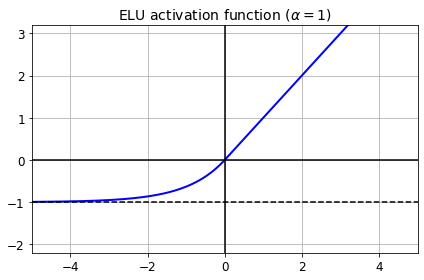

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1, -1], "k--")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
save_fig("elu_plot")
plt.show()

텐서플로에서 쉽게 ELU를 적용할 수 있다. 층을 만들 때 활성화 함수로 지정하면 된다:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

Günter Klambauer, Thomas Unterthiner, Andreas Mayr는 2017년 한 [훌륭한 논문](https://arxiv.org/pdf/1706.02515.pdf)에서 SELU 활성화 함수를 소개했다. 훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화된다. 각 층의 출력이 평균과
표준편차를 보존하는 경향이 있다. 이는 그레이디언트 소실과 폭주 문제를 막아 준다. 그 결과로 SELU 활성화 함수는 이런 종류의 네트워크(특히 아주 깊은 네트워크)에서 다른 활성화 함수보다 뛰어난 성능을 종종 낸다. 따라서 꼭 시도해 봐야 한다. 하지만 SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨진다. ℓ<sub>1</sub>나 ℓ<sub>2</sub> 정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지를 사용할 수 없다(즉 순환 신경망은 자기 정규화되지 않는다). 하지만 실전에서 시퀀셜 CNN과 잘 동작한다. 자기 정규화가 깨지면 SELU가 다른 활성화 함수보다 더 나은 성능을 내지 않을 것이다.

In [21]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화한다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (
        2 * erfc(np.sqrt(2)) * np.e ** 2 + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e - 2 * (2 + np.pi) * erfc(
    1 / np.sqrt(2)) * np.sqrt(np.e) + np.pi + 2) ** (-1 / 2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


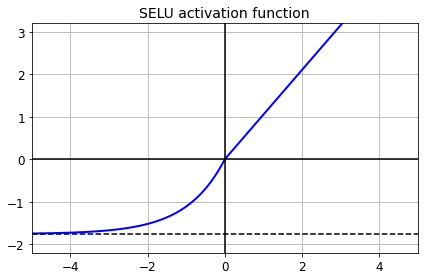

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1.758, -1.758], "k--")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
save_fig("selu_plot")
plt.show()

기본적으로 SELU 하이퍼파라미터(`scale`과 `alpha`)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정된다(입력은 평균이 0이고 표준 편차 1로 표준화되었다고 가정한다). 이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지한다. 이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있다:

In [24]:
Z = np.random.normal(size=(500, 100))  # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100))  # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print(f"Layer {layer}: mean {means:.2f}, std deviation {stds:.2f}")

Layer 0: mean 0.00, std deviation 0.99
Layer 100: mean -0.02, std deviation 0.87
Layer 200: mean -0.03, std deviation 0.93
Layer 300: mean -0.02, std deviation 0.90
Layer 400: mean -0.12, std deviation 0.87
Layer 500: mean -0.03, std deviation 0.87
Layer 600: mean -0.04, std deviation 0.89
Layer 700: mean -0.05, std deviation 0.84
Layer 800: mean 0.01, std deviation 0.99
Layer 900: mean -0.06, std deviation 0.90


쉽게 SELU를 사용할 수 있다:

In [25]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

100개의 은닉층과 SELU 활성화 함수를 사용한 패션 MNIST를 위한 신경망을 만들어 본다:

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

이제 훈련해 본다. 입력을 평균 0과 표준 편차 1로 바꾸어야 한다는 것을 잊지 않는다:

In [28]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [29]:
history = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 47s 26ms/step - loss: 1.5771 - accuracy: 0.4008 - val_loss: 1.4415 - val_accuracy: 0.3970
Epoch 2/5
1719/1719 [==============================] - 46s 27ms/step - loss: 1.0148 - accuracy: 0.6145 - val_loss: 1.1662 - val_accuracy: 0.6454
Epoch 3/5
1719/1719 [==============================] - 44s 26ms/step - loss: 0.7109 - accuracy: 0.7384 - val_loss: 0.7398 - val_accuracy: 0.7422
Epoch 4/5
1719/1719 [==============================] - 45s 26ms/step - loss: 0.6139 - accuracy: 0.7781 - val_loss: 0.5912 - val_accuracy: 0.7910
Epoch 5/5
1719/1719 [==============================] - 45s 26ms/step - loss: 0.5595 - accuracy: 0.8030 - val_loss: 0.5279 - val_accuracy: 0.8194


대신 ReLU 활성화 함수를 사용하면 어떤 일이 일어나는지 확인해 본다:

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [32]:
history = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 46s 25ms/step - loss: 2.0186 - accuracy: 0.2158 - val_loss: 1.9807 - val_accuracy: 0.2126
Epoch 2/5
1719/1719 [==============================] - 42s 24ms/step - loss: 1.5926 - accuracy: 0.3402 - val_loss: 1.4261 - val_accuracy: 0.4200
Epoch 3/5
1719/1719 [==============================] - 42s 25ms/step - loss: 1.2918 - accuracy: 0.4771 - val_loss: 1.0757 - val_accuracy: 0.5732
Epoch 4/5
1719/1719 [==============================] - 46s 27ms/step - loss: 1.0915 - accuracy: 0.5660 - val_loss: 1.2063 - val_accuracy: 0.5382
Epoch 5/5
1719/1719 [==============================] - 45s 26ms/step - loss: 1.0563 - accuracy: 0.5883 - val_loss: 0.9028 - val_accuracy: 0.6422


좋지 않다. 그레이디언트 폭주나 소실 문제가 발생한 것이다.

# 배치 정규화

In [33]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [35]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [36]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [37]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8355 - accuracy: 0.7178 - val_loss: 0.5450 - val_accuracy: 0.8168
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5674 - accuracy: 0.8050 - val_loss: 0.4672 - val_accuracy: 0.8404
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5065 - accuracy: 0.8236 - val_loss: 0.4313 - val_accuracy: 0.8504
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4752 - accuracy: 0.8350 - val_loss: 0.4103 - val_accuracy: 0.8594
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4533 - accuracy: 0.8407 - val_loss: 0.3950 - val_accuracy: 0.8638
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4365 - accuracy: 0.8465 - val_loss: 0.3835 - val_accuracy: 0.8662
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4199 - accuracy: 0.8507 - val_loss: 0.3758 - val_ac

이따금 활성화 함수 전에 BN을 적용해도 잘 동작한다(여기에는 논란의 여지가 있다). 또한 `BatchNormalization` 층 이전의 층은 편향을 위한 항이 필요 없다. `BatchNormalization` 층이 이를 무효화하기 때문이다. 따라서 필요 없는 파라미터이므로 `use_bias=False`를 지정하여 층을 만들 수 있다:

In [38]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dense(100, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [39]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [40]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.0360 - accuracy: 0.6771 - val_loss: 0.6732 - val_accuracy: 0.7894
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6799 - accuracy: 0.7810 - val_loss: 0.5551 - val_accuracy: 0.8190
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5943 - accuracy: 0.8034 - val_loss: 0.5030 - val_accuracy: 0.8348
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5501 - accuracy: 0.8147 - val_loss: 0.4690 - val_accuracy: 0.8436
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5144 - accuracy: 0.8251 - val_loss: 0.4455 - val_accuracy: 0.8492
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4931 - accuracy: 0.8316 - val_loss: 0.4298 - val_accuracy: 0.8540
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4737 - accuracy: 0.8372 - val_loss: 0.4159 - val_accuracy

## 그레이디언트 클리핑

모든 케라스 옵티마이저는 `clipnorm`이나 `clipvalue` 매개변수를 지원한다:

In [41]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [42]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전 훈련된 층 재사용하기

### 케라스 모델 재사용하기

패션 MNIST 훈련 세트를 두 개로 나누어 본다:
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

검증 세트와 테스트 세트도 이렇게 나눈다. 하지만 이미지 개수는 제한하지 않는다.

A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 본다. A 작업에서 B 작업으로 약간의 지식이 전달되기를 기대한다. 왜냐하면 A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷하기 때문이다. 하지만 `Dense` 층을 사용하기 때문에 동일한 위치에 나타난 패턴만 재사용할 수 있다(반대로 합성곱 층은 훨씬 많은 정보를 전송한다. 학습한 패턴을 이미지의 어느 위치에서나 감지할 수 있기 때문이다.).

In [43]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6)  # 샌들 또는 셔츠
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2  # 클래스 인덱스 7, 8, 9는 5, 6, 7로 이동해야 한다
    y_B = (y[y_5_or_6] == 6).astype(np.float32)  # 이진 분류 작업: 셔츠(클래스 6)인가?
    return (X[~y_5_or_6], y_A), (X[y_5_or_6], y_B)


(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [44]:
X_train_A.shape

(43986, 28, 28)

In [45]:
X_train_B.shape

(200, 28, 28)

In [46]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [47]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [48]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [49]:
model_A.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [50]:
history = model_A.fit(X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.5859 - accuracy: 0.8134 - val_loss: 0.3696 - val_accuracy: 0.8710
Epoch 2/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3532 - accuracy: 0.8774 - val_loss: 0.3368 - val_accuracy: 0.8799
Epoch 3/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3206 - accuracy: 0.8880 - val_loss: 0.3041 - val_accuracy: 0.8939
Epoch 4/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.3018 - accuracy: 0.8944 - val_loss: 0.2899 - val_accuracy: 0.8999
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2889 - accuracy: 0.8997 - val_loss: 0.2780 - val_accuracy: 0.9041
Epoch 6/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2790 - accuracy: 0.9040 - val_loss: 0.2688 - val_accuracy: 0.9058
Epoch 7/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2707 - accuracy: 0.9069 - val_loss: 0.2672 - val_accuracy:

In [51]:
model_A.save("my_model_A.h5")

In [52]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [53]:
model_B.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

In [54]:
history = model_B.fit(X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 47ms/step - loss: 0.6921 - accuracy: 0.5650 - val_loss: 0.5867 - val_accuracy: 0.7302
Epoch 2/20
7/7 [==============================] - 0s 22ms/step - loss: 0.5453 - accuracy: 0.7800 - val_loss: 0.4871 - val_accuracy: 0.8418
Epoch 3/20
7/7 [==============================] - 0s 20ms/step - loss: 0.4548 - accuracy: 0.8450 - val_loss: 0.4184 - val_accuracy: 0.8915
Epoch 4/20
7/7 [==============================] - 0s 20ms/step - loss: 0.3878 - accuracy: 0.9050 - val_loss: 0.3635 - val_accuracy: 0.9118
Epoch 5/20
7/7 [==============================] - 0s 20ms/step - loss: 0.3351 - accuracy: 0.9400 - val_loss: 0.3222 - val_accuracy: 0.9351
Epoch 6/20
7/7 [==============================] - 0s 21ms/step - loss: 0.2943 - accuracy: 0.9700 - val_loss: 0.2886 - val_accuracy: 0.9493
Epoch 7/20
7/7 [==============================] - 0s 20ms/step - loss: 0.2620 - accuracy: 0.9750 - val_loss: 0.2627 - val_accuracy: 0.9584
Epoch 8/20
7/7 [===========

In [55]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_224 (Dense)           (None, 300)               235500    
                                                                 
 dense_225 (Dense)           (None, 100)               30100     
                                                                 
 dense_226 (Dense)           (None, 50)                5050      
                                                                 
 dense_227 (Dense)           (None, 50)                2550      
                                                                 
 dense_228 (Dense)           (None, 50)                2550      
                                                                 
 dense_229 (Dense)           (None, 1)                

In [56]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

`model_B_on_A`와 `model_A`는 층을 공유하기 때문에 하나를 훈련하면 두 모델이 업데이트된다. 이를 피하려면 `model_A`를 클론한 것을 사용해 `model_B_on_A`를 만들어야 한다:

In [57]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [58]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [59]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 41ms/step - loss: 1.9941 - accuracy: 0.1600 - val_loss: 1.8696 - val_accuracy: 0.1856
Epoch 2/4
7/7 [==============================] - 0s 19ms/step - loss: 1.8275 - accuracy: 0.1900 - val_loss: 1.7174 - val_accuracy: 0.2028
Epoch 3/4
7/7 [==============================] - 0s 20ms/step - loss: 1.6758 - accuracy: 0.2100 - val_loss: 1.5778 - val_accuracy: 0.2373
Epoch 4/4
7/7 [==============================] - 0s 19ms/step - loss: 1.5370 - accuracy: 0.2400 - val_loss: 1.4422 - val_accuracy: 0.2576
Epoch 1/16
7/7 [==============================] - 1s 41ms/step - loss: 1.1272 - accuracy: 0.4250 - val_loss: 0.7530 - val_accuracy: 0.5913
Epoch 2/16
7/7 [==============================] - 0s 20ms/step - loss: 0.6504 - accuracy: 0.6350 - val_loss: 0.4978 - val_accuracy: 0.7373
Epoch 3/16
7/7 [==============================] - 0s 20ms/step - loss: 0.4494 - accuracy: 0.7750 - val_loss: 0.3623 - val_accuracy: 0.8387
Epoch 4/16
7/7 [===============

마지막 점수는 어떨까?

In [60]:
B = model_B.evaluate(X_test_B, y_test_B)
B

63/63 [==============================] - 0s 3ms/step - loss: 0.1250 - accuracy: 0.9865


[0.12497635930776596, 0.9865000247955322]

In [61]:
B_on_A = model_B_on_A.evaluate(X_test_B, y_test_B)
B_on_A

63/63 [==============================] - 0s 2ms/step - loss: 0.0830 - accuracy: 0.9830


[0.08295535296201706, 0.9829999804496765]

아주 약간의 정보를 전달했다: 오차율이 아주 조금 줄었다.

In [62]:
(100 - B[1]) / (100 - B_on_A[1])

0.9999646520865593

# 고속 옵티마이저

## 모멘텀 옵티마이저

In [63]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## 네스테로프 가속 경사

In [64]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [65]:
optimizer = keras.optimizers.Adagrad()

## RMSProp

In [66]:
optimizer = keras.optimizers.RMSprop()

## Adam 옵티마이저

In [67]:
optimizer = keras.optimizers.Adam()

## Nadam 옵티마이저

In [68]:
optimizer = keras.optimizers.Nadam()

## 학습률 스케줄링

### 거듭제곱 스케줄링

```lr = lr0 / (1 + steps / s)**c```
* 케라스는 `c=1`과 `s = 1 / decay`을 사용한다

In [69]:
optimizer = keras.optimizers.SGD(decay=1e-4)

In [70]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [71]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4883 - accuracy: 0.8301 - val_loss: 0.4091 - val_accuracy: 0.8598
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3806 - accuracy: 0.8655 - val_loss: 0.3805 - val_accuracy: 0.8704
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3477 - accuracy: 0.8758 - val_loss: 0.3635 - val_accuracy: 0.8702
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3257 - accuracy: 0.8843 - val_loss: 0.3635 - val_accuracy: 0.8678
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3096 - accuracy: 0.8896 - val_loss: 0.3460 - val_accuracy: 0.8762
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2968 - accuracy: 0.8944 - val_loss: 0.3425 - val_accuracy: 0.8784
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2866 - accuracy: 0.8974 - val_loss: 0.3314 - val_accuracy:

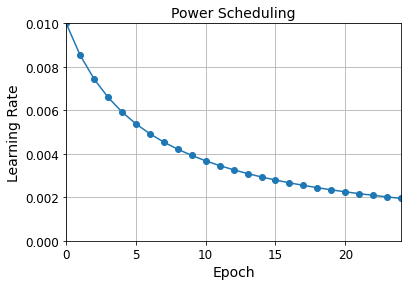

In [72]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)
plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케줄링

```lr = lr0 * 0.1**(epoch / s)```

In [73]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [74]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [75]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [76]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(
    X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler]
)

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8567 - accuracy: 0.7545 - val_loss: 0.8291 - val_accuracy: 0.7654 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7073 - accuracy: 0.7903 - val_loss: 0.8126 - val_accuracy: 0.7936 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6118 - accuracy: 0.8132 - val_loss: 0.6398 - val_accuracy: 0.8200 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5426 - accuracy: 0.8320 - val_loss: 0.6423 - val_accuracy: 0.8260 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4845 - accuracy: 0.8481 - val_loss: 0.6129 - val_accuracy: 0.8258 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4424 - accuracy: 0.8606 - val_loss: 0.5649 - val_accuracy: 0.8530 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

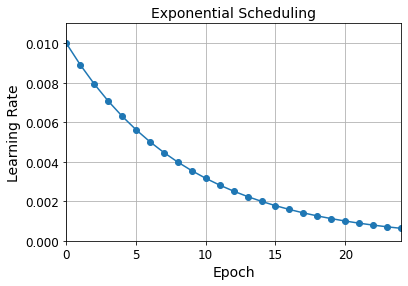

In [77]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

이 스케줄 함수는 두 번째 매개변수로 현재 학습률을 받을 수 있다:

In [78]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

에포크가 아니라 반복마다 학습률을 업데이트하려면 사용자 정의 콜백 클래스를 작성해야 한다:

In [79]:
K = keras.backend


class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정된다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1 ** (1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs["lr"] = K.get_value(self.model.optimizer.lr)


model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
s = 20 * len(X_train) // 32  # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(
    X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[exp_decay]
)

Epoch 1/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7895 - accuracy: 0.7696 - val_loss: 0.6371 - val_accuracy: 0.8132 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6297 - accuracy: 0.8058 - val_loss: 0.7267 - val_accuracy: 0.7492 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5626 - accuracy: 0.8277 - val_loss: 0.5640 - val_accuracy: 0.8232 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5163 - accuracy: 0.8409 - val_loss: 0.5995 - val_accuracy: 0.8350 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4528 - accuracy: 0.8576 - val_loss: 0.4872 - val_accuracy: 0.8504 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4326 - accuracy: 0.8659 - val_loss: 0.5164 - val_accuracy: 0.8510 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

In [80]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1 ** (steps / s)

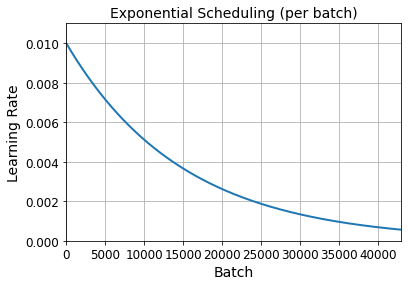

In [81]:
plt.plot(steps, lrs, '-', linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 기간별 고정 스케줄링

In [82]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [83]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)

    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]

    return piecewise_constant_fn


piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [84]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(
    X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler]
)

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8150 - accuracy: 0.7666 - val_loss: 0.6827 - val_accuracy: 0.7830 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8609 - accuracy: 0.7597 - val_loss: 1.2797 - val_accuracy: 0.7634 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9939 - accuracy: 0.6850 - val_loss: 1.0437 - val_accuracy: 0.5912 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.9186 - accuracy: 0.7024 - val_loss: 0.9011 - val_accuracy: 0.6734 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.9480 - accuracy: 0.6792 - val_loss: 0.9802 - val_accuracy: 0.6432 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6428 - accuracy: 0.7966 - val_loss: 0.6562 - val_accuracy: 0.8320 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

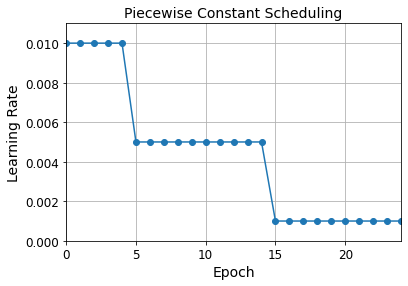

In [85]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [86]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(
    X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler]
)

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5926 - accuracy: 0.8071 - val_loss: 0.5480 - val_accuracy: 0.8314 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5063 - accuracy: 0.8365 - val_loss: 0.5032 - val_accuracy: 0.8406 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4829 - accuracy: 0.8483 - val_loss: 0.5777 - val_accuracy: 0.8420 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4947 - accuracy: 0.8486 - val_loss: 0.5080 - val_accuracy: 0.8442 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4918 - accuracy: 0.8539 - val_loss: 0.5540 - val_accuracy: 0.8260 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4943 - accuracy: 0.8572 - val_loss: 0.6887 - val_accuracy: 0.8384 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 6s

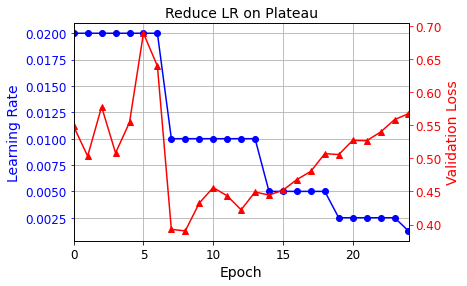

In [87]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)
ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel("Validation Loss", color='r')
ax2.tick_params('y', colors='r')
plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras 스케줄러

In [88]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
s = 20 * len(X_train) // 32  # 20 Epoch의 단계 수 (배치 크기 = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4895 - accuracy: 0.8285 - val_loss: 0.4149 - val_accuracy: 0.8516
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3810 - accuracy: 0.8645 - val_loss: 0.3860 - val_accuracy: 0.8662
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3470 - accuracy: 0.8757 - val_loss: 0.3659 - val_accuracy: 0.8678
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3246 - accuracy: 0.8841 - val_loss: 0.3552 - val_accuracy: 0.8784
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3078 - accuracy: 0.8906 - val_loss: 0.3473 - val_accuracy: 0.8738
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2944 - accuracy: 0.8951 - val_loss: 0.3406 - val_accuracy: 0.8794
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2832 - accuracy: 0.8990 - val_loss: 0.3334 - val_accuracy:

구간별 고정 스케줄링은 다음을 사용한다:

In [89]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch], values=[0.01, 0.005, 0.001]
)

### 1사이클 스케줄링

In [90]:
K = keras.backend


class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)


def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10 ** -5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses


def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale("log")
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

**경고**: `on_batch_end()` 메서드에서 `logs["loss"]`로 (에포크의) 평균 손실을 모은다. 이런 이유로 아래 그래프가 부드럽다. 이는 그래프에서 배치 손실이 폭주하기 시작하는 지점과 그렇지 않은 지점 사이에 지연이 있다는 뜻이다. 따라서 변동이 심한 그래프에서는 조금 더 작은 학습률을 선택해야 한다. 또한 `ExponentialLearningRate` 콜백을 조금 바꾸어 (현재 평균 손실과 이전 평균 손실을 기반으로) 배치 손실을 계산할 수 있다:

```python
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.prev_loss = None
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0

    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
```

In [91]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

430/430 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.3567


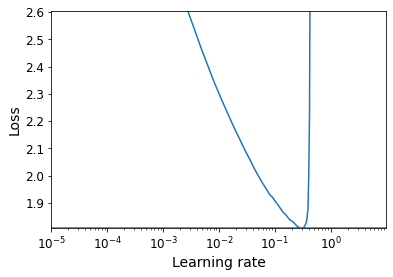

In [92]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [93]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, rate1, rate2):
        return (rate2 - rate1) * (self.iteration - iter1) / (iter2 - iter1) + rate1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations, self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [94]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[onecycle]
)

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.6574 - accuracy: 0.7733 - val_loss: 0.4866 - val_accuracy: 0.8276
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4557 - accuracy: 0.8397 - val_loss: 0.4373 - val_accuracy: 0.8556
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4102 - accuracy: 0.8554 - val_loss: 0.4049 - val_accuracy: 0.8640
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3820 - accuracy: 0.8656 - val_loss: 0.3908 - val_accuracy: 0.8670
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3595 - accuracy: 0.8741 - val_loss: 0.3755 - val_accuracy: 0.8720
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3411 - accuracy: 0.8790 - val_loss: 0.3767 - val_accuracy: 0.8664
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3258 - accuracy: 0.8835 - val_loss: 0.3656 - val_accuracy: 0.8734
Epoch 

In [95]:
layer = keras.layers.Dense(
    100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2()
)
# 또는 인수 0.1의 ℓ1 정규화에 대해 l1(0.1)
# 또는 l1_l2(0.1, 0.01) ℓ1 및 ℓ2 정규화에 대해 각각 0.1 및 0.01 인수

In [96]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(
            300, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2()
        ),
        keras.layers.Dense(
            100, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2()
        ),
        keras.layers.Dense(10, activation="softmax", kernel_regularizer=keras.regularizers.l2())
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 1.6022 - accuracy: 0.8118 - val_loss: 0.7056 - val_accuracy: 0.8446
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7208 - accuracy: 0.8255 - val_loss: 0.6958 - val_accuracy: 0.8344


In [97]:
from functools import partial

RegularizedDense = partial(
    keras.layers.Dense, activation="elu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2()
)
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        RegularizedDense(300),
        RegularizedDense(100),
        RegularizedDense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 1.6745 - accuracy: 0.8137 - val_loss: 0.7357 - val_accuracy: 0.8238
Epoch 2/2
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7229 - accuracy: 0.8258 - val_loss: 0.7116 - val_accuracy: 0.8222


## 드롭아웃

In [98]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5620 - accuracy: 0.8037 - val_loss: 0.3707 - val_accuracy: 0.8642
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4187 - accuracy: 0.8465 - val_loss: 0.3471 - val_accuracy: 0.8700


## 알파 드롭아웃

In [99]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.AlphaDropout(rate=0.2),
        keras.layers.Dense(10, activation="softmax")
    ]
)
optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6668 - accuracy: 0.7563 - val_loss: 0.6167 - val_accuracy: 0.8402
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5587 - accuracy: 0.7936 - val_loss: 0.5672 - val_accuracy: 0.8432
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5230 - accuracy: 0.8056 - val_loss: 0.5410 - val_accuracy: 0.8544
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5047 - accuracy: 0.8140 - val_loss: 0.5320 - val_accuracy: 0.8522
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4910 - accuracy: 0.8170 - val_loss: 0.4847 - val_accuracy: 0.8594
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4841 - accuracy: 0.8213 - val_loss: 0.4744 - val_accuracy: 0.8570
Epoch 7/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4722 - accuracy: 0.8257 - val_loss: 0.4658 - val_accuracy:

In [100]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4967 - accuracy: 0.8633


[0.49666905403137207, 0.8633000254631042]

In [101]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 5s 3ms/step - loss: 0.3656 - accuracy: 0.8843


[0.3655565083026886, 0.8842909336090088]

In [102]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 7s 4ms/step - loss: 0.4118 - accuracy: 0.8459


## MC 드롭아웃

In [103]:
y_probas = np.stack([model(X_test_scaled, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [104]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 92ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98]],
      dtype=float32)

In [105]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.96]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.21, 0.  , 0.68]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.54, 0.  , 0.33]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.43, 0.  , 0.52]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.16, 0.  , 0.81]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.79]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.93, 0.  , 0.05, 0.  , 0.02]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.15, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.1 , 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.73]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.18, 0.  , 0.82]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.07, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.08, 0.  , 0

In [106]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.22, 0.  , 0.68]],
      dtype=float32)

In [107]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.19, 0.02, 0.26]],
      dtype=float32)

In [108]:
y_pred = np.argmax(y_proba, axis=1)

In [109]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8697

In [110]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)


class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [111]:
isinstance(model.layers[1], keras.layers.AlphaDropout)

True

In [112]:
mc_model = keras.models.Sequential(
    [MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers]
)

In [113]:
mc_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_263 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_264 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [114]:
optimizer = keras.optimizers.SGD(momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [115]:
mc_model.set_weights(model.get_weights())

이제 MC 드롭아웃을 모델에 사용할 수 있다:

In [116]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 22ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.21, 0.  , 0.67]],
      dtype=float32)

## 맥스 노름

In [117]:
layer = keras.layers.Dense(
    100, activation="selu", kernel_initializer="lecun_normal", kernel_constraint=keras.constraints.max_norm(1.)
)

In [118]:
MaxNormDense = partial(
    keras.layers.Dense,
    activation="selu",
    kernel_initializer="lecun_normal",
    kernel_constraint=keras.constraints.max_norm(1.)
)
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        MaxNormDense(300),
        MaxNormDense(100),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4778 - accuracy: 0.8329 - val_loss: 0.4565 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3580 - accuracy: 0.8690 - val_loss: 0.3492 - val_accuracy: 0.8768


# 연습

## 1. CIFAR10에서 딥러닝

### a.
*100개의 뉴런을 가진 은닉층 20개로 심층 신경망을 만들어 본다(너무 많은 것 같지만 이 연습의 핵심이다). He 초기화와 ELU 활성화 함수를 사용한다.*

In [119]:
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"))

### b.
*Nadam 옵티마이저와 조기 종료를 사용하여 CIFAR10 데이터셋에 이 네트워크를 훈련한다. `keras.datasets.cifar10.load_ data()`를 사용하여 데이터를 적재할 수 있다. 이 데이터셋은 10개의 클래스와 32×32 크기의 컬러 이미지 60,000개로 구성된다(50,000개는 훈련, 10,000개는 테스트). 따라서 10개의 뉴런과 소프트맥스 활성화 함수를 사용하는 출력층이 필요하다. 모델 구조와 하이퍼파라미터를 바꿀 때마다 적절한 학습률을 찾아야 한다는 것을 기억한다.*

모델에 출력층을 추가한다:

In [120]:
model.add(keras.layers.Dense(10, activation="softmax"))

학습률 5e-5인 Nadam 옵티마이저를 사용해 본다. 학습률 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2를 테스트하고 10번의 에포크 동안 (아래 텐서보드 콜백으로) 학습 곡선을 비교해 보았다. 학습률 3e-5와 1e-4가 꽤 좋았기 때문에 5e-5를 시도해 보았고 조금 더 나은 결과를 냈다.

In [121]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

CIFAR10 데이터셋을 로드한다. 조기 종료를 사용하기 때문에 검증 세트가 필요하다. 원본 훈련 세트에서 처음 5,000개를 검증 세트로 사용하겠다:

In [122]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

이제 콜백을 만들고 모델을 훈련한다:

In [123]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1  # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_{run_index:03d}")
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

아래 셀에 있는 `tensorboard` 명령을 실행하면 다음과 같은 텐서보드 화면을 볼 수 있다.

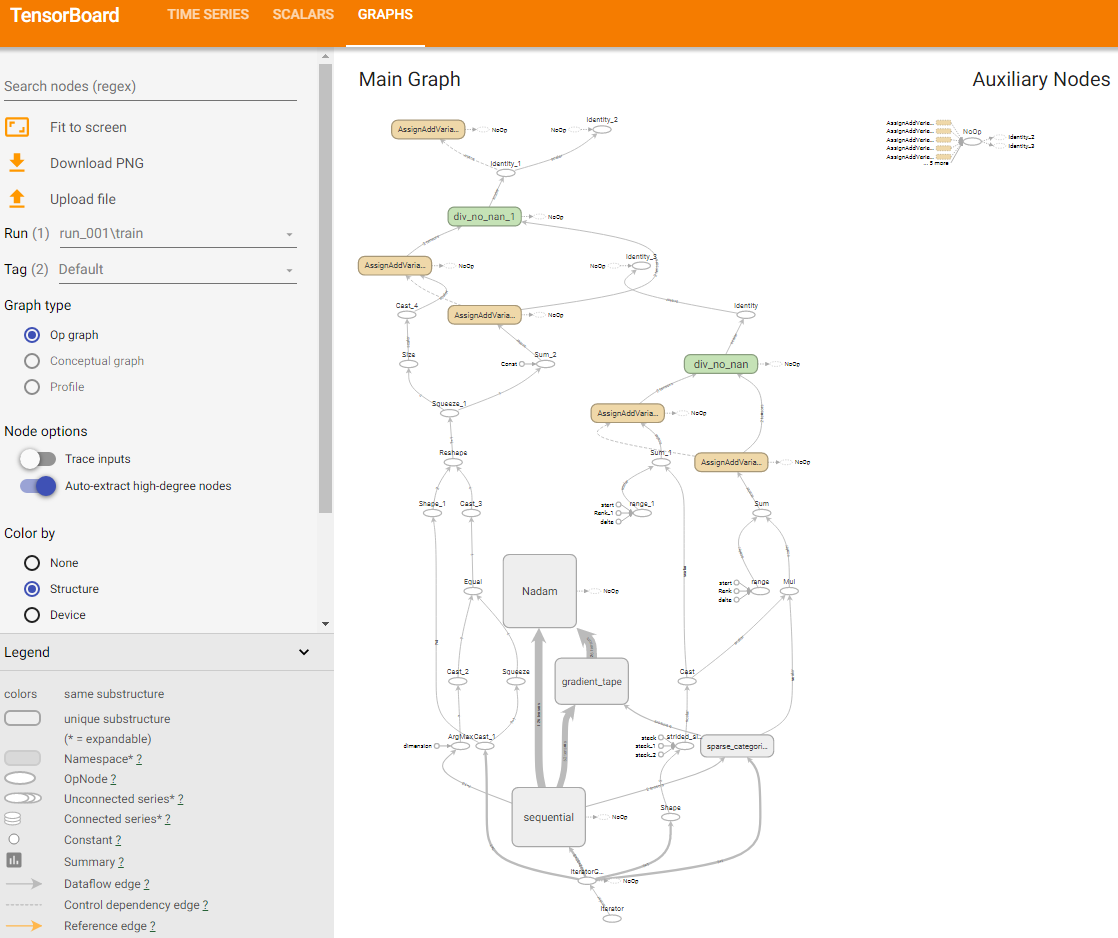

```bash
tensorboard --logdir=./my_cifar10_logs --port=6006
```

In [124]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 39s 26ms/step - loss: 6.4607 - accuracy: 0.1546 - val_loss: 2.2671 - val_accuracy: 0.1954
Epoch 2/100
1407/1407 [==============================] - 37s 26ms/step - loss: 2.1224 - accuracy: 0.2249 - val_loss: 2.0175 - val_accuracy: 0.2704
Epoch 3/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.9681 - accuracy: 0.2803 - val_loss: 1.9092 - val_accuracy: 0.2970
Epoch 4/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.8836 - accuracy: 0.3120 - val_loss: 1.8252 - val_accuracy: 0.3250
Epoch 5/100
1407/1407 [==============================] - 36s 25ms/step - loss: 1.8210 - accuracy: 0.3372 - val_loss: 1.7871 - val_accuracy: 0.3496
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.7676 - accuracy: 0.3546 - val_loss: 1.7383 - val_accuracy: 0.3710
Epoch 7/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.7248 - accuracy: 0.3750 - val_loss: 1

In [125]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4948 - accuracy: 0.4800


[1.4947749376296997, 0.47999998927116394]

가장 낮은 검증 손실을 내는 모델은 검증 세트에서 약 48.0% 정확도를 얻었다. 이 검증 점수에 도달하는데 35번의 에포크가 걸렸다. (GPU가 있는) 본 컴퓨터에서 에포크당 약 37초 정도 걸렸다. 배치 정규화를 사용해 성능을 올릴 수 있는지 확인해 본다.

### c.
*배치 정규화를 추가하고 학습 곡선을 비교해 본다. 이전보다 빠르게 수렴할까? 더 좋은 모델이 만들어질까? 훈련 속도에는 어떤 영향을 미칠까?*

다음 코드는 위의 코드와 배우 비슷하다. 몇 가지 다른 점은 아래와 같다:

* 출력층을 제외하고 모든 `Dense` 층 다음에 (활성화 함수 전에) BN 층을 추가했다. 처음 은닉층 전에도 BN 층을 추가했다.
* 학습률을 5e-4로 바꾸었다. 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3를 시도해 보고 20번 에포크 후에 검증 세트 성능이 가장 좋은 것을 선택했다.
* run_logdir를 run_bn_* 으로 이름을 바꾸고 모델 파일 이름을 my_cifar10_bn_model.h5로 변경했다.

In [126]:
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1  # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_bn_{run_index:03d}")
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=callbacks)
model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 103s 67ms/step - loss: 1.8380 - accuracy: 0.3427 - val_loss: 1.6729 - val_accuracy: 0.3954
Epoch 2/100
1407/1407 [==============================] - 88s 62ms/step - loss: 1.6598 - accuracy: 0.4112 - val_loss: 1.5862 - val_accuracy: 0.4328
Epoch 3/100
1407/1407 [==============================] - 89s 63ms/step - loss: 1.5974 - accuracy: 0.4326 - val_loss: 1.5391 - val_accuracy: 0.4484
Epoch 4/100
1407/1407 [==============================] - 91s 65ms/step - loss: 1.5449 - accuracy: 0.4510 - val_loss: 1.4847 - val_accuracy: 0.4692
Epoch 5/100
1407/1407 [==============================] - 92s 65ms/step - loss: 1.5052 - accuracy: 0.4645 - val_loss: 1.4590 - val_accuracy: 0.4778
Epoch 6/100
1407/1407 [==============================] - 91s 65ms/step - loss: 1.4667 - accuracy: 0.4801 - val_loss: 1.4634 - val_accuracy: 0.4756
Epoch 7/100
1407/1407 [==============================] - 92s 65ms/step - loss: 1.4345 - accuracy: 0.4910 - val_loss: 

[1.3168394565582275, 0.5497999787330627]

* *이전보다 빠르게 수렴할까?* 훨씬 빠르다! 이전 모델은 가장 낮은 검증 손실에 도달하기 위해 35 에포크가 걸렸지만 새 모델은 동일한 손실에 도달하는데 4 에포크가 걸렸고 24 에포크까지 계속 줄어든다. 이전 모델보다 두 배 이상 빠르다. BN 층은 훈련을 안정적으로 수행하고 더 큰 학습률을 사용할 수 있기 때문에 수렴이 빨라졌다.
* *BN이 더 좋은 모델을 만들까?* 그렇다! 최종 모델의 성능이 48.0%가 아니라 55.0% 정확도로 더 좋다. 이는 아주 좋은 모델이 아니지만 적어도 이전보다는 낫다(합성곱 신경망이 더 낫겠지만 이는 다른 주제이다.).
* *BN이 훈련 속도에 영향을 미칠까?* 모델이 훨씬 빠르게 수렴했지만 각 에포크는 37초가 아니라 96초가 걸렸다. BN 층에서 추가된 계산 때문이다. 하지만 전반적인 훈련 시간(탁상 시계 시간)은 크게 줄었다!

### d.
*배치 정규화를 SELU로 바꾸어 본다. 네트워크가 자기 정규화하기 위해 필요한 변경 사항을 적용한다(즉, 입력 특성 표준화, 르쿤 정규분포 초기화, 완전 연결 층만 순차적으로 쌓은 심층 신경망 등).*

In [127]:
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))
optimizer = keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1  # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_selu_{run_index:03d}")
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds
model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks)
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 41s 27ms/step - loss: 1.9389 - accuracy: 0.3058 - val_loss: 1.8463 - val_accuracy: 0.3426
Epoch 2/100
1407/1407 [==============================] - 40s 28ms/step - loss: 1.7199 - accuracy: 0.3923 - val_loss: 1.7203 - val_accuracy: 0.3618
Epoch 3/100
1407/1407 [==============================] - 40s 29ms/step - loss: 1.6285 - accuracy: 0.4244 - val_loss: 1.6384 - val_accuracy: 0.4166
Epoch 4/100
1407/1407 [==============================] - 40s 28ms/step - loss: 1.5582 - accuracy: 0.4533 - val_loss: 1.6566 - val_accuracy: 0.4270
Epoch 5/100
1407/1407 [==============================] - 40s 28ms/step - loss: 1.5027 - accuracy: 0.4748 - val_loss: 1.5972 - val_accuracy: 0.4496
Epoch 6/100
1407/1407 [==============================] - 40s 28ms/step - loss: 1.4619 - accuracy: 0.4894 - val_loss: 1.5634 - val_accuracy: 0.4674
Epoch 7/100
1407/1407 [==============================] - 38s 27ms/step - loss: 1.4170 - accuracy: 0.5060 - val_loss: 1

[1.4550639390945435, 0.49900001287460327]

In [130]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

157/157 [==============================] - 1s 4ms/step - loss: 1.4551 - accuracy: 0.4990


[1.4550639390945435, 0.49900001287460327]

49.9% 정확도를 얻었다. 원래 모델(48.0%)보다 크게 높지 않다. 배치 정규화를 사용한 모델(55.0%)만큼 좋지도 않다. 하지만 BN 모델만큼 빠르게 수렴했다. 각 에포크는 35초만 걸렸다. 따라서 이 모델이 지금까지 가장 빠른 모델이다.

### e.
*알파 드롭아웃으로 모델에 규제를 적용해 본다. 그다음 모델을 다시 훈련하지 않고 MC 드롭아웃으로 더 높은 정확도를 얻을 수 있는지 확인해 본다.*

In [128]:
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))
optimizer = keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1  # 모델을 훈련할 때마다 증가시킴
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", f"run_alpha_dropout_{run_index:03d}")
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]
X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds
model.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks)
model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 41s 27ms/step - loss: 1.9135 - accuracy: 0.3225 - val_loss: 1.8163 - val_accuracy: 0.3480
Epoch 2/100
1407/1407 [==============================] - 35s 25ms/step - loss: 1.6569 - accuracy: 0.4151 - val_loss: 1.6364 - val_accuracy: 0.4250
Epoch 3/100
1407/1407 [==============================] - 40s 28ms/step - loss: 1.5660 - accuracy: 0.4515 - val_loss: 1.6510 - val_accuracy: 0.4292
Epoch 4/100
1407/1407 [==============================] - 39s 27ms/step - loss: 1.4981 - accuracy: 0.4781 - val_loss: 1.5706 - val_accuracy: 0.4492
Epoch 5/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.4436 - accuracy: 0.4924 - val_loss: 1.5441 - val_accuracy: 0.4750
Epoch 6/100
1407/1407 [==============================] - 34s 24ms/step - loss: 1.3950 - accuracy: 0.5096 - val_loss: 1.6240 - val_accuracy: 0.4734
Epoch 7/100
1407/1407 [==============================] - 37s 26ms/step - loss: 1.3502 - accuracy: 0.5273 - val_loss: 1

[1.544118881225586, 0.4749999940395355]

이 모델은 검증 세트에서 47.5% 정확도에 도달한다. 드롭아웃이 없을 때보다(48.0%) 조금 더 나쁘다. 하이퍼파라미터 탐색을 좀 많이 수행해 보면 더 나아질 수 있다(드롭아웃 비율 5%, 10%, 20%, 40%과 학습률 1e-4, 3e-4, 5e-4, 1e-3을 시도했다). 하지만 이 경우에는 크지 않을 것 같다.

이제 MC 드롭아웃을 사용해 본다. 앞서 사용한 `MCAlphaDropout` 클래스를 복사해 사용하겠다:

In [131]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

방금 훈련했던 모델과 (같은 가중치를 가진) 동일한 새로운 모델을 만들어 본다. 하지만 `AlphaDropout` 층 대신 `MCAlphaDropout` 드롭아웃 층을 사용한다:

In [132]:
mc_model = keras.models.Sequential(
    [MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer for layer in model.layers]
)

그다음 몇 가지 유틸리티 함수를 추가한다. 첫 번째 함수는 모델을 여러 번 실행한다(기본적으로 10번). 그다음 평균한 예측 클래스 확률을 반환한다. 두 번째 함수는 이 평균 확률을 사용해 각 샘플의 클래스를 예측한다:

In [133]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for _ in range(n_samples)]
    return np.mean(Y_probas, axis=0)


def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

이제 검증 세트의 모든 샘플에 대해 예측을 만들고 정확도를 계산해 본다:

In [134]:
keras.backend.clear_session()
y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

157/157 [==============================] - 0s 2ms/step


0.499

이 경우에는 정확도 향상이 조금 있다(정확도는 49.9%이다).

따라서 이 연습에서 얻은 최상의 모델은 배치 정규화 모델이다.

### f.
*1 사이클 스케줄링으로 모델을 다시 훈련하고 훈련 속도와 모델 정확도가 향상되는지 확인해 본다.*

In [142]:
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

352/352 [==============================] - 3s 10ms/step - loss: nan - accuracy: 0.1386           


(9.999999747378752e-06,
 9.615227699279785,
 2.6080405712127686,
 3.9178688185555597)

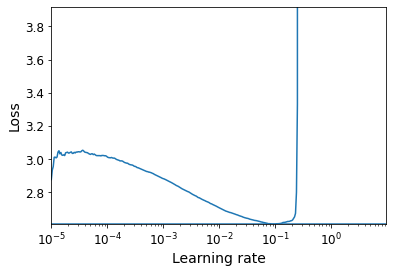

In [149]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [152]:
keras.backend.clear_session()
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))
optimizer = keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [153]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[onecycle]
)

Epoch 1/15
352/352 [==============================] - 4s 10ms/step - loss: 2.0467 - accuracy: 0.2835 - val_loss: 1.8023 - val_accuracy: 0.3686
Epoch 2/15
352/352 [==============================] - 3s 9ms/step - loss: 1.7666 - accuracy: 0.3759 - val_loss: 1.6931 - val_accuracy: 0.4060
Epoch 3/15
352/352 [==============================] - 3s 10ms/step - loss: 1.6264 - accuracy: 0.4228 - val_loss: 1.6124 - val_accuracy: 0.4310
Epoch 4/15
352/352 [==============================] - 3s 9ms/step - loss: 1.5489 - accuracy: 0.4509 - val_loss: 1.6624 - val_accuracy: 0.4316
Epoch 5/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4977 - accuracy: 0.4687 - val_loss: 1.6256 - val_accuracy: 0.4408
Epoch 6/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4583 - accuracy: 0.4830 - val_loss: 1.6112 - val_accuracy: 0.4456
Epoch 7/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4219 - accuracy: 0.4956 - val_loss: 1.6457 - val_accuracy: 0.4532
Epoc

1 사이클 방식을 사용해 모델을 15 에포크 동안 훈련했다. (큰 배치 크기 덕분에) 각 에포크는 3초만 걸렸다. 이는 지금까지 훈련한 가장 빠른 모델보다 몇 배 더 빠르다. 또한 모델 성능도 올라갔다(48.0%에서 52.4%). 배치 정규화 모델이 조금 더 성능(55%)이 높지만 훈련 속도가 더 느리다.